In [1]:
from os import listdir
from os.path import isdir, join
import librosa
import random
import numpy as np
import matplotlib.pyplot as plt
import python_speech_features

In [2]:
dataset_path = 'data/data_speech_commands_v0.02'

In [3]:
# Create an all targets list
all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
all_targets.remove('_background_noise_')
print(all_targets)

['zero', 'four', 'three', 'right', 'cat', 'tree', 'happy', 'one', 'wow', 'up', 'down', 'house', 'marvin', 'two', 'yes', 'nine', 'bird', 'learn', 'sheila', 'dog', 'bed', 'eight', 'on', 'stop', 'left', 'forward', 'six', 'off', 'visual', 'five', 'backward', 'go', 'no', 'seven', 'follow']


In [4]:
# See how many files are in each
num_samples = 0
for target in all_targets:
    print(len(listdir(join(dataset_path, target))))
    num_samples += len(listdir(join(dataset_path, target)))
print('Total samples:', num_samples)

4052
3728
3727
3778
2031
1759
2054
3890
2123
3723
3917
2113
2100
3880
4044
3934
2064
1575
2022
2128
2014
3787
3845
3872
3801
1557
3860
3745
1592
4052
1664
3880
3941
3998
1579
Total samples: 105829


In [5]:
# Settings
target_list = all_targets
feature_sets_file = 'all_targets_mfcc_sets.npz'
perc_keep_samples = 1.0 # 1.0 is keep all samples
val_ratio = 0.1
test_ratio = 0.1
sample_rate = 8000
num_mfcc = 16
len_mfcc = 16

In [6]:
# Create list of filenames along with ground truth vector (y)
filenames = []
y = []
for index, target in enumerate(target_list):
    print(join(dataset_path, target))
    filenames.append(listdir(join(dataset_path, target)))
    y.append(np.ones(len(filenames[index])) * index)

data/data_speech_commands_v0.02/zero
data/data_speech_commands_v0.02/four
data/data_speech_commands_v0.02/three
data/data_speech_commands_v0.02/right
data/data_speech_commands_v0.02/cat
data/data_speech_commands_v0.02/tree
data/data_speech_commands_v0.02/happy
data/data_speech_commands_v0.02/one
data/data_speech_commands_v0.02/wow
data/data_speech_commands_v0.02/up
data/data_speech_commands_v0.02/down
data/data_speech_commands_v0.02/house
data/data_speech_commands_v0.02/marvin
data/data_speech_commands_v0.02/two
data/data_speech_commands_v0.02/yes
data/data_speech_commands_v0.02/nine
data/data_speech_commands_v0.02/bird
data/data_speech_commands_v0.02/learn
data/data_speech_commands_v0.02/sheila
data/data_speech_commands_v0.02/dog
data/data_speech_commands_v0.02/bed
data/data_speech_commands_v0.02/eight
data/data_speech_commands_v0.02/on
data/data_speech_commands_v0.02/stop
data/data_speech_commands_v0.02/left
data/data_speech_commands_v0.02/forward
data/data_speech_commands_v0.02/six


In [7]:
# Check ground truth Y vector
print(y)
for item in y:
    print(len(item))

[array([0., 0., 0., ..., 0., 0., 0.]), array([1., 1., 1., ..., 1., 1., 1.]), array([2., 2., 2., ..., 2., 2., 2.]), array([3., 3., 3., ..., 3., 3., 3.]), array([4., 4., 4., ..., 4., 4., 4.]), array([5., 5., 5., ..., 5., 5., 5.]), array([6., 6., 6., ..., 6., 6., 6.]), array([7., 7., 7., ..., 7., 7., 7.]), array([8., 8., 8., ..., 8., 8., 8.]), array([9., 9., 9., ..., 9., 9., 9.]), array([10., 10., 10., ..., 10., 10., 10.]), array([11., 11., 11., ..., 11., 11., 11.]), array([12., 12., 12., ..., 12., 12., 12.]), array([13., 13., 13., ..., 13., 13., 13.]), array([14., 14., 14., ..., 14., 14., 14.]), array([15., 15., 15., ..., 15., 15., 15.]), array([16., 16., 16., ..., 16., 16., 16.]), array([17., 17., 17., ..., 17., 17., 17.]), array([18., 18., 18., ..., 18., 18., 18.]), array([19., 19., 19., ..., 19., 19., 19.]), array([20., 20., 20., ..., 20., 20., 20.]), array([21., 21., 21., ..., 21., 21., 21.]), array([22., 22., 22., ..., 22., 22., 22.]), array([23., 23., 23., ..., 23., 23., 23.]), arr

In [8]:
# Flatten filename and y vectors
filenames = [item for sublist in filenames for item in sublist]
y = [item for sublist in y for item in sublist]

In [9]:
# Associate filenames with true output and shuffle
filenames_y = list(zip(filenames, y))
random.shuffle(filenames_y)
filenames, y = zip(*filenames_y)

In [10]:
# Only keep the specified number of samples (shorter extraction/training)
print(len(filenames))
filenames = filenames[:int(len(filenames) * perc_keep_samples)]
print(len(filenames))

105829
105829


In [11]:
# Calculate validation and test set sizes
val_set_size = int(len(filenames) * val_ratio)
test_set_size = int(len(filenames) * test_ratio)

In [12]:
# Break dataset apart into train, validation, and test sets
filenames_val = filenames[:val_set_size]
filenames_test = filenames[val_set_size:(val_set_size + test_set_size)]
filenames_train = filenames[(val_set_size + test_set_size):]

In [13]:
# Break y apart into train, validation, and test sets
y_orig_val = y[:val_set_size]
y_orig_test = y[val_set_size:(val_set_size + test_set_size)]
y_orig_train = y[(val_set_size + test_set_size):]

In [14]:
def signal_to_mfcc(signal, fs):
    # Create MFCCs from sound clip
    mfccs = python_speech_features.base.mfcc(signal, 
                                            samplerate=fs,
                                            winlen=0.256,
                                            winstep=0.050,
                                            numcep=num_mfcc,
                                            nfilt=26,
                                            nfft=2048,
                                            preemph=0.0,
                                            ceplifter=0,
                                            appendEnergy=False,
                                            winfunc=np.hanning)
    return mfccs.transpose()

In [15]:
# Function: Create MFCC from given path
def calc_mfcc(path):
    # Load wavefile
    signal, fs = librosa.load(path, sr=sample_rate)
    return signal_to_mfcc(signal, fs)

In [16]:
james_stop_word = np.load('stop.npy').squeeze()

In [17]:
james_stop_word_mfccs = signal_to_mfcc(james_stop_word, len(james_stop_word))

In [18]:
from tensorflow.keras import layers, models

In [19]:
model = models.load_model('wake_word_stop_model.h5')

In [20]:
model.predict(james_stop_word_mfccs.reshape((1, 16, 16, 1)))

array([[0.00949889]], dtype=float32)

In [21]:
model.predict(calc_mfcc('james_stop_word.wav').reshape((1, 16, 16, 1)))

array([[0.00949889]], dtype=float32)

In [22]:
# TEST: Construct test set by computing MFCC of each WAV file
prob_cnt = 0
x_test = []
y_test = []
for index, filename in enumerate(filenames_train):
    # Stop after 500
    if index >= 500:
        break
    
    # Create path from given filename and target item
    path = join(dataset_path, target_list[int(y_orig_train[index])], 
                filename)
    
    # Create MFCCs
    mfccs = calc_mfcc(path)
    
    if mfccs.shape[1] == len_mfcc:
        x_test.append(mfccs)
        y_test.append(y_orig_train[index])
    else:
        print('Dropped:', index, mfccs.shape)
        prob_cnt += 1

Dropped: 18 (16, 12)
Dropped: 31 (16, 11)
Dropped: 42 (16, 15)
Dropped: 45 (16, 14)
Dropped: 58 (16, 12)
Dropped: 61 (16, 14)
Dropped: 79 (16, 9)
Dropped: 80 (16, 7)
Dropped: 100 (16, 14)
Dropped: 106 (16, 11)
Dropped: 108 (16, 15)
Dropped: 114 (16, 13)
Dropped: 116 (16, 14)
Dropped: 133 (16, 14)
Dropped: 135 (16, 13)
Dropped: 149 (16, 14)
Dropped: 169 (16, 7)
Dropped: 176 (16, 14)
Dropped: 179 (16, 15)
Dropped: 191 (16, 15)
Dropped: 199 (16, 15)
Dropped: 204 (16, 14)
Dropped: 206 (16, 12)
Dropped: 239 (16, 15)
Dropped: 242 (16, 7)
Dropped: 249 (16, 15)
Dropped: 257 (16, 12)
Dropped: 260 (16, 15)
Dropped: 279 (16, 5)
Dropped: 280 (16, 12)
Dropped: 297 (16, 15)
Dropped: 306 (16, 11)
Dropped: 307 (16, 8)
Dropped: 320 (16, 13)
Dropped: 334 (16, 12)
Dropped: 339 (16, 8)
Dropped: 344 (16, 11)
Dropped: 363 (16, 10)
Dropped: 364 (16, 6)
Dropped: 379 (16, 14)
Dropped: 383 (16, 13)
Dropped: 416 (16, 15)
Dropped: 422 (16, 9)
Dropped: 430 (16, 14)
Dropped: 436 (16, 11)
Dropped: 443 (16, 8)
Droppe

In [24]:
print('% of problematic samples:', prob_cnt / 500)

% of problematic samples: 0.096


MFCCs: [[-3.38251074e+01 -3.53970512e+01 -3.05846059e+01 -1.45422269e+01
  -4.22120339e+00  3.20365153e-01  5.08707651e-01 -3.96795028e+00
  -1.46966178e+01 -2.11116879e+01 -2.12530726e+01 -2.36366566e+01
  -2.71289679e+01 -3.11488765e+01 -3.45279225e+01 -3.55884849e+01]
 [ 5.87032802e+00  8.31690363e+00  9.65219767e+00  7.20853910e+00
   4.08634939e+00  2.12778214e+00  1.91110860e+00  3.45904603e+00
   7.36226308e+00  1.05157584e+01  1.04619171e+01  1.02083088e+01
   1.01342380e+01  9.44861427e+00  8.56728400e+00  8.38676416e+00]
 [ 3.46613425e+00  1.90417849e+00 -3.37750650e-01 -2.91906332e+00
  -4.67318875e+00 -5.35964037e+00 -4.88417724e+00 -3.71406449e+00
  -1.61868334e+00  4.52045529e+00  6.11573093e+00  5.92717043e+00
   4.97606071e+00  3.11251079e+00  1.62576007e+00  1.74631072e+00]
 [ 3.04709517e+00  2.89574127e+00 -3.78723435e-01 -3.07070902e+00
  -3.62531636e+00 -3.40062785e+00 -2.59790118e+00 -1.95984007e+00
  -6.77981430e-01 -9.78555511e-01 -3.08683478e+00 -3.43617390e+00


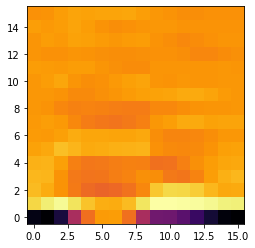

In [25]:
# TEST: Test shorter MFCC
# !pip install playsound
from playsound import playsound

idx = 13

# Create path from given filename and target item
path = join(dataset_path, target_list[int(y_orig_train[idx])], 
            filenames_train[idx])

# Create MFCCs
mfccs = calc_mfcc(path)
print("MFCCs:", mfccs)

# Plot MFCC
fig = plt.figure()
plt.imshow(mfccs, cmap='inferno', origin='lower')

# TEST: Play problem sounds
print(target_list[int(y_orig_train[idx])])
playsound(path)

In [26]:
# Function: Create MFCCs, keeping only ones of desired length
def extract_features(in_files, in_y):
    prob_cnt = 0
    out_x = []
    out_y = []
        
    for index, filename in enumerate(in_files):
        # Create path from given filename and target item
        path = join(dataset_path, target_list[int(in_y[index])], 
                    filename)
        
        # Check to make sure we're reading a .wav file
        if not path.endswith('.wav'):
            continue

        # Create MFCCs
        mfccs = calc_mfcc(path)

        # Only keep MFCCs with given length
        if mfccs.shape[1] == len_mfcc:
            out_x.append(mfccs)
            out_y.append(in_y[index])
        else:
            print('Dropped:', index, mfccs.shape)
            prob_cnt += 1
            
    return out_x, out_y, prob_cnt

In [27]:
# Create train, validation, and test sets
x_train, y_train, prob = extract_features(filenames_train, 
                                          y_orig_train)
print('Removed percentage:', prob / len(y_orig_train))
x_val, y_val, prob = extract_features(filenames_val, y_orig_val)
print('Removed percentage:', prob / len(y_orig_val))
x_test, y_test, prob = extract_features(filenames_test, y_orig_test)
print('Removed percentage:', prob / len(y_orig_test))

Dropped: 18 (16, 12)
Dropped: 31 (16, 11)
Dropped: 42 (16, 15)
Dropped: 45 (16, 14)
Dropped: 58 (16, 12)
Dropped: 61 (16, 14)
Dropped: 79 (16, 9)
Dropped: 80 (16, 7)
Dropped: 100 (16, 14)
Dropped: 106 (16, 11)
Dropped: 108 (16, 15)
Dropped: 114 (16, 13)
Dropped: 116 (16, 14)
Dropped: 133 (16, 14)
Dropped: 135 (16, 13)
Dropped: 149 (16, 14)
Dropped: 169 (16, 7)
Dropped: 176 (16, 14)
Dropped: 179 (16, 15)
Dropped: 191 (16, 15)
Dropped: 199 (16, 15)
Dropped: 204 (16, 14)
Dropped: 206 (16, 12)
Dropped: 239 (16, 15)
Dropped: 242 (16, 7)
Dropped: 249 (16, 15)
Dropped: 257 (16, 12)
Dropped: 260 (16, 15)
Dropped: 279 (16, 5)
Dropped: 280 (16, 12)
Dropped: 297 (16, 15)
Dropped: 306 (16, 11)
Dropped: 307 (16, 8)
Dropped: 320 (16, 13)
Dropped: 334 (16, 12)
Dropped: 339 (16, 8)
Dropped: 344 (16, 11)
Dropped: 363 (16, 10)
Dropped: 364 (16, 6)
Dropped: 379 (16, 14)
Dropped: 383 (16, 13)
Dropped: 416 (16, 15)
Dropped: 422 (16, 9)
Dropped: 430 (16, 14)
Dropped: 436 (16, 11)
Dropped: 443 (16, 8)
Droppe

Dropped: 3956 (16, 14)
Dropped: 3958 (16, 10)
Dropped: 3971 (16, 10)
Dropped: 3982 (16, 13)
Dropped: 3984 (16, 7)
Dropped: 3993 (16, 13)
Dropped: 4005 (16, 15)
Dropped: 4030 (16, 12)
Dropped: 4031 (16, 12)
Dropped: 4057 (16, 12)
Dropped: 4063 (16, 11)
Dropped: 4083 (16, 11)
Dropped: 4087 (16, 7)
Dropped: 4107 (16, 10)
Dropped: 4110 (16, 13)
Dropped: 4119 (16, 12)
Dropped: 4124 (16, 8)
Dropped: 4127 (16, 9)
Dropped: 4145 (16, 13)
Dropped: 4150 (16, 15)
Dropped: 4167 (16, 14)
Dropped: 4168 (16, 10)
Dropped: 4190 (16, 15)
Dropped: 4196 (16, 15)
Dropped: 4209 (16, 7)
Dropped: 4218 (16, 10)
Dropped: 4228 (16, 11)
Dropped: 4259 (16, 13)
Dropped: 4286 (16, 14)
Dropped: 4299 (16, 9)
Dropped: 4306 (16, 13)
Dropped: 4312 (16, 12)
Dropped: 4322 (16, 15)
Dropped: 4338 (16, 12)
Dropped: 4339 (16, 14)
Dropped: 4347 (16, 14)
Dropped: 4353 (16, 13)
Dropped: 4362 (16, 14)
Dropped: 4371 (16, 9)
Dropped: 4409 (16, 12)
Dropped: 4419 (16, 14)
Dropped: 4449 (16, 12)
Dropped: 4467 (16, 8)
Dropped: 4482 (16, 

Dropped: 7958 (16, 9)
Dropped: 7966 (16, 14)
Dropped: 7985 (16, 12)
Dropped: 7988 (16, 11)
Dropped: 7999 (16, 14)
Dropped: 8004 (16, 13)
Dropped: 8006 (16, 11)
Dropped: 8018 (16, 12)
Dropped: 8040 (16, 15)
Dropped: 8074 (16, 10)
Dropped: 8078 (16, 7)
Dropped: 8087 (16, 8)
Dropped: 8096 (16, 8)
Dropped: 8100 (16, 14)
Dropped: 8105 (16, 13)
Dropped: 8115 (16, 10)
Dropped: 8133 (16, 13)
Dropped: 8138 (16, 14)
Dropped: 8181 (16, 15)
Dropped: 8204 (16, 15)
Dropped: 8205 (16, 7)
Dropped: 8232 (16, 15)
Dropped: 8237 (16, 13)
Dropped: 8273 (16, 14)
Dropped: 8280 (16, 12)
Dropped: 8292 (16, 11)
Dropped: 8304 (16, 10)
Dropped: 8311 (16, 15)
Dropped: 8352 (16, 10)
Dropped: 8374 (16, 11)
Dropped: 8384 (16, 12)
Dropped: 8386 (16, 14)
Dropped: 8423 (16, 11)
Dropped: 8426 (16, 15)
Dropped: 8452 (16, 7)
Dropped: 8465 (16, 12)
Dropped: 8466 (16, 14)
Dropped: 8467 (16, 13)
Dropped: 8473 (16, 12)
Dropped: 8488 (16, 15)
Dropped: 8496 (16, 14)
Dropped: 8535 (16, 11)
Dropped: 8557 (16, 8)
Dropped: 8581 (16,

Dropped: 12199 (16, 12)
Dropped: 12201 (16, 14)
Dropped: 12210 (16, 8)
Dropped: 12220 (16, 14)
Dropped: 12222 (16, 12)
Dropped: 12241 (16, 10)
Dropped: 12247 (16, 10)
Dropped: 12258 (16, 13)
Dropped: 12259 (16, 15)
Dropped: 12269 (16, 11)
Dropped: 12273 (16, 14)
Dropped: 12296 (16, 15)
Dropped: 12301 (16, 13)
Dropped: 12307 (16, 12)
Dropped: 12334 (16, 15)
Dropped: 12349 (16, 9)
Dropped: 12367 (16, 11)
Dropped: 12376 (16, 13)
Dropped: 12387 (16, 7)
Dropped: 12398 (16, 8)
Dropped: 12405 (16, 14)
Dropped: 12416 (16, 11)
Dropped: 12421 (16, 13)
Dropped: 12424 (16, 10)
Dropped: 12426 (16, 15)
Dropped: 12427 (16, 12)
Dropped: 12428 (16, 11)
Dropped: 12431 (16, 8)
Dropped: 12437 (16, 12)
Dropped: 12442 (16, 12)
Dropped: 12443 (16, 11)
Dropped: 12445 (16, 12)
Dropped: 12455 (16, 13)
Dropped: 12463 (16, 14)
Dropped: 12493 (16, 9)
Dropped: 12515 (16, 11)
Dropped: 12535 (16, 15)
Dropped: 12554 (16, 10)
Dropped: 12570 (16, 10)
Dropped: 12581 (16, 12)
Dropped: 12582 (16, 12)
Dropped: 12585 (16, 15

Dropped: 16042 (16, 14)
Dropped: 16043 (16, 12)
Dropped: 16050 (16, 12)
Dropped: 16051 (16, 15)
Dropped: 16052 (16, 15)
Dropped: 16056 (16, 12)
Dropped: 16059 (16, 14)
Dropped: 16060 (16, 14)
Dropped: 16064 (16, 11)
Dropped: 16077 (16, 15)
Dropped: 16094 (16, 13)
Dropped: 16095 (16, 6)
Dropped: 16109 (16, 8)
Dropped: 16112 (16, 11)
Dropped: 16115 (16, 13)
Dropped: 16121 (16, 8)
Dropped: 16152 (16, 13)
Dropped: 16165 (16, 9)
Dropped: 16181 (16, 7)
Dropped: 16189 (16, 13)
Dropped: 16201 (16, 13)
Dropped: 16203 (16, 13)
Dropped: 16217 (16, 10)
Dropped: 16224 (16, 13)
Dropped: 16227 (16, 15)
Dropped: 16243 (16, 8)
Dropped: 16246 (16, 13)
Dropped: 16260 (16, 13)
Dropped: 16266 (16, 8)
Dropped: 16267 (16, 8)
Dropped: 16283 (16, 11)
Dropped: 16298 (16, 9)
Dropped: 16300 (16, 7)
Dropped: 16320 (16, 13)
Dropped: 16321 (16, 13)
Dropped: 16323 (16, 10)
Dropped: 16331 (16, 11)
Dropped: 16358 (16, 7)
Dropped: 16364 (16, 10)
Dropped: 16372 (16, 15)
Dropped: 16376 (16, 8)
Dropped: 16393 (16, 15)
Drop

Dropped: 19824 (16, 13)
Dropped: 19827 (16, 13)
Dropped: 19836 (16, 13)
Dropped: 19842 (16, 8)
Dropped: 19854 (16, 12)
Dropped: 19877 (16, 7)
Dropped: 19887 (16, 6)
Dropped: 19888 (16, 15)
Dropped: 19892 (16, 12)
Dropped: 19907 (16, 8)
Dropped: 19912 (16, 13)
Dropped: 19919 (16, 11)
Dropped: 19945 (16, 11)
Dropped: 19968 (16, 12)
Dropped: 20017 (16, 11)
Dropped: 20030 (16, 5)
Dropped: 20039 (16, 10)
Dropped: 20043 (16, 13)
Dropped: 20044 (16, 14)
Dropped: 20046 (16, 13)
Dropped: 20051 (16, 11)
Dropped: 20061 (16, 14)
Dropped: 20064 (16, 12)
Dropped: 20072 (16, 13)
Dropped: 20077 (16, 15)
Dropped: 20148 (16, 12)
Dropped: 20160 (16, 9)
Dropped: 20170 (16, 15)
Dropped: 20192 (16, 14)
Dropped: 20203 (16, 14)
Dropped: 20209 (16, 8)
Dropped: 20213 (16, 11)
Dropped: 20231 (16, 15)
Dropped: 20235 (16, 8)
Dropped: 20236 (16, 15)
Dropped: 20242 (16, 13)
Dropped: 20248 (16, 12)
Dropped: 20251 (16, 15)
Dropped: 20267 (16, 15)
Dropped: 20270 (16, 8)
Dropped: 20279 (16, 15)
Dropped: 20284 (16, 10)
D

Dropped: 24224 (16, 13)
Dropped: 24243 (16, 15)
Dropped: 24266 (16, 11)
Dropped: 24268 (16, 12)
Dropped: 24278 (16, 13)
Dropped: 24293 (16, 15)
Dropped: 24296 (16, 11)
Dropped: 24331 (16, 14)
Dropped: 24344 (16, 14)
Dropped: 24352 (16, 12)
Dropped: 24354 (16, 14)
Dropped: 24383 (16, 5)
Dropped: 24399 (16, 12)
Dropped: 24412 (16, 14)
Dropped: 24452 (16, 14)
Dropped: 24469 (16, 15)
Dropped: 24472 (16, 11)
Dropped: 24475 (16, 14)
Dropped: 24492 (16, 14)
Dropped: 24498 (16, 15)
Dropped: 24509 (16, 11)
Dropped: 24510 (16, 10)
Dropped: 24527 (16, 15)
Dropped: 24586 (16, 11)
Dropped: 24598 (16, 15)
Dropped: 24654 (16, 13)
Dropped: 24658 (16, 15)
Dropped: 24679 (16, 11)
Dropped: 24690 (16, 15)
Dropped: 24705 (16, 13)
Dropped: 24757 (16, 14)
Dropped: 24760 (16, 13)
Dropped: 24797 (16, 12)
Dropped: 24805 (16, 10)
Dropped: 24812 (16, 14)
Dropped: 24813 (16, 15)
Dropped: 24824 (16, 11)
Dropped: 24830 (16, 13)
Dropped: 24831 (16, 6)
Dropped: 24851 (16, 11)
Dropped: 24858 (16, 15)
Dropped: 24863 (16

Dropped: 28610 (16, 11)
Dropped: 28618 (16, 11)
Dropped: 28621 (16, 15)
Dropped: 28625 (16, 11)
Dropped: 28634 (16, 9)
Dropped: 28636 (16, 11)
Dropped: 28637 (16, 14)
Dropped: 28642 (16, 7)
Dropped: 28651 (16, 12)
Dropped: 28657 (16, 10)
Dropped: 28668 (16, 7)
Dropped: 28678 (16, 8)
Dropped: 28692 (16, 15)
Dropped: 28700 (16, 15)
Dropped: 28712 (16, 12)
Dropped: 28736 (16, 13)
Dropped: 28752 (16, 11)
Dropped: 28757 (16, 13)
Dropped: 28763 (16, 13)
Dropped: 28772 (16, 9)
Dropped: 28779 (16, 13)
Dropped: 28797 (16, 15)
Dropped: 28811 (16, 11)
Dropped: 28843 (16, 7)
Dropped: 28845 (16, 13)
Dropped: 28857 (16, 15)
Dropped: 28868 (16, 13)
Dropped: 28873 (16, 9)
Dropped: 28878 (16, 12)
Dropped: 28879 (16, 13)
Dropped: 28925 (16, 11)
Dropped: 28937 (16, 14)
Dropped: 28953 (16, 11)
Dropped: 28982 (16, 15)
Dropped: 28986 (16, 9)
Dropped: 29005 (16, 12)
Dropped: 29007 (16, 10)
Dropped: 29019 (16, 13)
Dropped: 29032 (16, 14)
Dropped: 29033 (16, 10)
Dropped: 29036 (16, 13)
Dropped: 29054 (16, 9)
D

Dropped: 32407 (16, 13)
Dropped: 32412 (16, 11)
Dropped: 32419 (16, 15)
Dropped: 32421 (16, 13)
Dropped: 32423 (16, 12)
Dropped: 32511 (16, 7)
Dropped: 32518 (16, 10)
Dropped: 32519 (16, 14)
Dropped: 32544 (16, 15)
Dropped: 32546 (16, 14)
Dropped: 32563 (16, 7)
Dropped: 32566 (16, 14)
Dropped: 32587 (16, 15)
Dropped: 32604 (16, 13)
Dropped: 32613 (16, 13)
Dropped: 32622 (16, 13)
Dropped: 32628 (16, 12)
Dropped: 32634 (16, 8)
Dropped: 32641 (16, 9)
Dropped: 32657 (16, 7)
Dropped: 32667 (16, 11)
Dropped: 32683 (16, 12)
Dropped: 32714 (16, 12)
Dropped: 32725 (16, 11)
Dropped: 32732 (16, 9)
Dropped: 32735 (16, 13)
Dropped: 32742 (16, 13)
Dropped: 32760 (16, 9)
Dropped: 32772 (16, 11)
Dropped: 32781 (16, 13)
Dropped: 32806 (16, 8)
Dropped: 32812 (16, 15)
Dropped: 32819 (16, 7)
Dropped: 32824 (16, 11)
Dropped: 32827 (16, 11)
Dropped: 32836 (16, 13)
Dropped: 32853 (16, 14)
Dropped: 32854 (16, 7)
Dropped: 32876 (16, 11)
Dropped: 32879 (16, 15)
Dropped: 32892 (16, 11)
Dropped: 32895 (16, 14)
Dr

Dropped: 36528 (16, 12)
Dropped: 36580 (16, 13)
Dropped: 36622 (16, 13)
Dropped: 36633 (16, 12)
Dropped: 36636 (16, 11)
Dropped: 36649 (16, 14)
Dropped: 36658 (16, 9)
Dropped: 36662 (16, 14)
Dropped: 36663 (16, 10)
Dropped: 36682 (16, 5)
Dropped: 36688 (16, 11)
Dropped: 36731 (16, 15)
Dropped: 36734 (16, 14)
Dropped: 36740 (16, 8)
Dropped: 36750 (16, 12)
Dropped: 36763 (16, 11)
Dropped: 36781 (16, 13)
Dropped: 36782 (16, 13)
Dropped: 36786 (16, 4)
Dropped: 36802 (16, 13)
Dropped: 36829 (16, 15)
Dropped: 36831 (16, 7)
Dropped: 36848 (16, 11)
Dropped: 36855 (16, 14)
Dropped: 36870 (16, 15)
Dropped: 36872 (16, 15)
Dropped: 36881 (16, 12)
Dropped: 36898 (16, 10)
Dropped: 36901 (16, 7)
Dropped: 36940 (16, 5)
Dropped: 36947 (16, 15)
Dropped: 36965 (16, 11)
Dropped: 36975 (16, 8)
Dropped: 36977 (16, 13)
Dropped: 36980 (16, 11)
Dropped: 36993 (16, 14)
Dropped: 37000 (16, 12)
Dropped: 37002 (16, 8)
Dropped: 37005 (16, 13)
Dropped: 37010 (16, 15)
Dropped: 37017 (16, 14)
Dropped: 37041 (16, 14)
D

Dropped: 40287 (16, 12)
Dropped: 40293 (16, 7)
Dropped: 40306 (16, 12)
Dropped: 40315 (16, 13)
Dropped: 40321 (16, 14)
Dropped: 40341 (16, 14)
Dropped: 40345 (16, 12)
Dropped: 40355 (16, 8)
Dropped: 40360 (16, 10)
Dropped: 40384 (16, 14)
Dropped: 40409 (16, 13)
Dropped: 40412 (16, 5)
Dropped: 40415 (16, 14)
Dropped: 40416 (16, 8)
Dropped: 40428 (16, 12)
Dropped: 40447 (16, 14)
Dropped: 40462 (16, 9)
Dropped: 40468 (16, 10)
Dropped: 40491 (16, 9)
Dropped: 40498 (16, 12)
Dropped: 40512 (16, 11)
Dropped: 40516 (16, 14)
Dropped: 40548 (16, 15)
Dropped: 40557 (16, 12)
Dropped: 40565 (16, 15)
Dropped: 40570 (16, 11)
Dropped: 40573 (16, 15)
Dropped: 40574 (16, 13)
Dropped: 40575 (16, 13)
Dropped: 40580 (16, 11)
Dropped: 40584 (16, 9)
Dropped: 40603 (16, 14)
Dropped: 40605 (16, 15)
Dropped: 40611 (16, 15)
Dropped: 40657 (16, 13)
Dropped: 40658 (16, 8)
Dropped: 40698 (16, 14)
Dropped: 40701 (16, 14)
Dropped: 40708 (16, 7)
Dropped: 40722 (16, 15)
Dropped: 40729 (16, 13)
Dropped: 40733 (16, 10)
D

Dropped: 44560 (16, 13)
Dropped: 44564 (16, 12)
Dropped: 44600 (16, 15)
Dropped: 44628 (16, 15)
Dropped: 44636 (16, 14)
Dropped: 44686 (16, 12)
Dropped: 44691 (16, 13)
Dropped: 44692 (16, 15)
Dropped: 44698 (16, 11)
Dropped: 44705 (16, 11)
Dropped: 44717 (16, 6)
Dropped: 44721 (16, 8)
Dropped: 44724 (16, 8)
Dropped: 44741 (16, 10)
Dropped: 44742 (16, 13)
Dropped: 44747 (16, 15)
Dropped: 44748 (16, 14)
Dropped: 44751 (16, 12)
Dropped: 44773 (16, 11)
Dropped: 44784 (16, 14)
Dropped: 44806 (16, 13)
Dropped: 44818 (16, 8)
Dropped: 44819 (16, 13)
Dropped: 44829 (16, 13)
Dropped: 44838 (16, 13)
Dropped: 44845 (16, 14)
Dropped: 44848 (16, 15)
Dropped: 44851 (16, 15)
Dropped: 44869 (16, 13)
Dropped: 44896 (16, 8)
Dropped: 44898 (16, 14)
Dropped: 44910 (16, 14)
Dropped: 44916 (16, 15)
Dropped: 44944 (16, 15)
Dropped: 44947 (16, 7)
Dropped: 44960 (16, 12)
Dropped: 44978 (16, 13)
Dropped: 45003 (16, 15)
Dropped: 45011 (16, 15)
Dropped: 45014 (16, 11)
Dropped: 45016 (16, 10)
Dropped: 45039 (16, 10

Dropped: 48384 (16, 12)
Dropped: 48398 (16, 12)
Dropped: 48401 (16, 8)
Dropped: 48411 (16, 10)
Dropped: 48420 (16, 15)
Dropped: 48448 (16, 14)
Dropped: 48466 (16, 15)
Dropped: 48473 (16, 14)
Dropped: 48488 (16, 14)
Dropped: 48514 (16, 11)
Dropped: 48519 (16, 14)
Dropped: 48522 (16, 7)
Dropped: 48529 (16, 5)
Dropped: 48553 (16, 12)
Dropped: 48561 (16, 13)
Dropped: 48565 (16, 14)
Dropped: 48568 (16, 11)
Dropped: 48573 (16, 15)
Dropped: 48579 (16, 8)
Dropped: 48618 (16, 11)
Dropped: 48635 (16, 11)
Dropped: 48654 (16, 11)
Dropped: 48659 (16, 13)
Dropped: 48681 (16, 14)
Dropped: 48692 (16, 14)
Dropped: 48693 (16, 15)
Dropped: 48699 (16, 14)
Dropped: 48700 (16, 14)
Dropped: 48701 (16, 14)
Dropped: 48705 (16, 8)
Dropped: 48708 (16, 14)
Dropped: 48727 (16, 15)
Dropped: 48744 (16, 15)
Dropped: 48745 (16, 12)
Dropped: 48747 (16, 13)
Dropped: 48757 (16, 15)
Dropped: 48759 (16, 13)
Dropped: 48775 (16, 11)
Dropped: 48806 (16, 12)
Dropped: 48813 (16, 12)
Dropped: 48814 (16, 10)
Dropped: 48816 (16, 1

Dropped: 52313 (16, 13)
Dropped: 52321 (16, 12)
Dropped: 52353 (16, 5)
Dropped: 52365 (16, 13)
Dropped: 52368 (16, 14)
Dropped: 52375 (16, 14)
Dropped: 52407 (16, 13)
Dropped: 52418 (16, 14)
Dropped: 52445 (16, 12)
Dropped: 52447 (16, 10)
Dropped: 52455 (16, 10)
Dropped: 52460 (16, 13)
Dropped: 52465 (16, 11)
Dropped: 52480 (16, 10)
Dropped: 52506 (16, 7)
Dropped: 52508 (16, 13)
Dropped: 52512 (16, 9)
Dropped: 52541 (16, 6)
Dropped: 52554 (16, 13)
Dropped: 52567 (16, 15)
Dropped: 52571 (16, 11)
Dropped: 52593 (16, 14)
Dropped: 52615 (16, 15)
Dropped: 52649 (16, 14)
Dropped: 52655 (16, 12)
Dropped: 52671 (16, 14)
Dropped: 52689 (16, 15)
Dropped: 52698 (16, 9)
Dropped: 52704 (16, 9)
Dropped: 52719 (16, 12)
Dropped: 52722 (16, 11)
Dropped: 52732 (16, 15)
Dropped: 52747 (16, 10)
Dropped: 52784 (16, 12)
Dropped: 52793 (16, 12)
Dropped: 52817 (16, 7)
Dropped: 52830 (16, 13)
Dropped: 52835 (16, 10)
Dropped: 52838 (16, 11)
Dropped: 52857 (16, 10)
Dropped: 52860 (16, 12)
Dropped: 52875 (16, 15)

Dropped: 56764 (16, 14)
Dropped: 56765 (16, 13)
Dropped: 56772 (16, 14)
Dropped: 56773 (16, 9)
Dropped: 56774 (16, 9)
Dropped: 56776 (16, 7)
Dropped: 56807 (16, 13)
Dropped: 56812 (16, 13)
Dropped: 56821 (16, 12)
Dropped: 56823 (16, 15)
Dropped: 56831 (16, 7)
Dropped: 56836 (16, 15)
Dropped: 56838 (16, 11)
Dropped: 56848 (16, 11)
Dropped: 56849 (16, 12)
Dropped: 56885 (16, 15)
Dropped: 56893 (16, 12)
Dropped: 56895 (16, 13)
Dropped: 56898 (16, 7)
Dropped: 56903 (16, 11)
Dropped: 56914 (16, 11)
Dropped: 56931 (16, 11)
Dropped: 56933 (16, 15)
Dropped: 56943 (16, 11)
Dropped: 56951 (16, 7)
Dropped: 56966 (16, 11)
Dropped: 56972 (16, 13)
Dropped: 56973 (16, 9)
Dropped: 56979 (16, 10)
Dropped: 56989 (16, 10)
Dropped: 57005 (16, 12)
Dropped: 57009 (16, 15)
Dropped: 57054 (16, 6)
Dropped: 57075 (16, 15)
Dropped: 57076 (16, 9)
Dropped: 57080 (16, 9)
Dropped: 57082 (16, 11)
Dropped: 57086 (16, 13)
Dropped: 57090 (16, 12)
Dropped: 57097 (16, 8)
Dropped: 57119 (16, 13)
Dropped: 57125 (16, 11)
Dro

Dropped: 60989 (16, 12)
Dropped: 61003 (16, 11)
Dropped: 61052 (16, 15)
Dropped: 61073 (16, 15)
Dropped: 61078 (16, 13)
Dropped: 61103 (16, 14)
Dropped: 61121 (16, 6)
Dropped: 61125 (16, 11)
Dropped: 61134 (16, 12)
Dropped: 61153 (16, 14)
Dropped: 61177 (16, 15)
Dropped: 61184 (16, 15)
Dropped: 61187 (16, 12)
Dropped: 61189 (16, 8)
Dropped: 61201 (16, 12)
Dropped: 61220 (16, 15)
Dropped: 61229 (16, 15)
Dropped: 61237 (16, 10)
Dropped: 61254 (16, 9)
Dropped: 61265 (16, 13)
Dropped: 61274 (16, 9)
Dropped: 61279 (16, 15)
Dropped: 61291 (16, 11)
Dropped: 61294 (16, 9)
Dropped: 61296 (16, 11)
Dropped: 61323 (16, 13)
Dropped: 61330 (16, 10)
Dropped: 61346 (16, 8)
Dropped: 61382 (16, 14)
Dropped: 61406 (16, 9)
Dropped: 61435 (16, 9)
Dropped: 61476 (16, 7)
Dropped: 61505 (16, 15)
Dropped: 61514 (16, 15)
Dropped: 61526 (16, 11)
Dropped: 61556 (16, 15)
Dropped: 61563 (16, 7)
Dropped: 61569 (16, 15)
Dropped: 61578 (16, 10)
Dropped: 61584 (16, 13)
Dropped: 61589 (16, 12)
Dropped: 61596 (16, 14)
Dr

Dropped: 65492 (16, 15)
Dropped: 65499 (16, 6)
Dropped: 65503 (16, 14)
Dropped: 65520 (16, 12)
Dropped: 65538 (16, 14)
Dropped: 65539 (16, 9)
Dropped: 65546 (16, 12)
Dropped: 65564 (16, 15)
Dropped: 65592 (16, 11)
Dropped: 65596 (16, 13)
Dropped: 65620 (16, 15)
Dropped: 65623 (16, 12)
Dropped: 65624 (16, 14)
Dropped: 65630 (16, 9)
Dropped: 65640 (16, 6)
Dropped: 65659 (16, 13)
Dropped: 65671 (16, 7)
Dropped: 65680 (16, 15)
Dropped: 65703 (16, 11)
Dropped: 65711 (16, 13)
Dropped: 65713 (16, 10)
Dropped: 65730 (16, 13)
Dropped: 65735 (16, 13)
Dropped: 65786 (16, 15)
Dropped: 65826 (16, 15)
Dropped: 65837 (16, 12)
Dropped: 65845 (16, 12)
Dropped: 65848 (16, 15)
Dropped: 65858 (16, 10)
Dropped: 65870 (16, 12)
Dropped: 65872 (16, 15)
Dropped: 65882 (16, 8)
Dropped: 65883 (16, 9)
Dropped: 65887 (16, 13)
Dropped: 65917 (16, 12)
Dropped: 65922 (16, 13)
Dropped: 65925 (16, 14)
Dropped: 65929 (16, 13)
Dropped: 65931 (16, 14)
Dropped: 65938 (16, 14)
Dropped: 65942 (16, 13)
Dropped: 65955 (16, 8)


Dropped: 69580 (16, 14)
Dropped: 69591 (16, 15)
Dropped: 69595 (16, 11)
Dropped: 69597 (16, 15)
Dropped: 69616 (16, 3)
Dropped: 69621 (16, 10)
Dropped: 69627 (16, 12)
Dropped: 69643 (16, 14)
Dropped: 69648 (16, 15)
Dropped: 69670 (16, 13)
Dropped: 69676 (16, 14)
Dropped: 69686 (16, 10)
Dropped: 69691 (16, 15)
Dropped: 69694 (16, 15)
Dropped: 69699 (16, 5)
Dropped: 69702 (16, 14)
Dropped: 69705 (16, 15)
Dropped: 69722 (16, 9)
Dropped: 69732 (16, 12)
Dropped: 69753 (16, 13)
Dropped: 69761 (16, 12)
Dropped: 69762 (16, 12)
Dropped: 69771 (16, 13)
Dropped: 69773 (16, 8)
Dropped: 69783 (16, 13)
Dropped: 69787 (16, 13)
Dropped: 69795 (16, 15)
Dropped: 69807 (16, 12)
Dropped: 69841 (16, 12)
Dropped: 69842 (16, 9)
Dropped: 69850 (16, 15)
Dropped: 69851 (16, 4)
Dropped: 69859 (16, 14)
Dropped: 69900 (16, 11)
Dropped: 69904 (16, 14)
Dropped: 69926 (16, 12)
Dropped: 69949 (16, 13)
Dropped: 69954 (16, 12)
Dropped: 69963 (16, 9)
Dropped: 69966 (16, 15)
Dropped: 69989 (16, 8)
Dropped: 69990 (16, 12)


Dropped: 73581 (16, 14)
Dropped: 73590 (16, 13)
Dropped: 73601 (16, 3)
Dropped: 73605 (16, 13)
Dropped: 73613 (16, 9)
Dropped: 73618 (16, 15)
Dropped: 73640 (16, 13)
Dropped: 73662 (16, 14)
Dropped: 73666 (16, 13)
Dropped: 73671 (16, 7)
Dropped: 73683 (16, 14)
Dropped: 73691 (16, 10)
Dropped: 73692 (16, 14)
Dropped: 73698 (16, 11)
Dropped: 73715 (16, 13)
Dropped: 73739 (16, 13)
Dropped: 73741 (16, 13)
Dropped: 73752 (16, 13)
Dropped: 73766 (16, 11)
Dropped: 73776 (16, 8)
Dropped: 73795 (16, 12)
Dropped: 73806 (16, 10)
Dropped: 73825 (16, 11)
Dropped: 73826 (16, 13)
Dropped: 73861 (16, 14)
Dropped: 73866 (16, 10)
Dropped: 73883 (16, 14)
Dropped: 73886 (16, 11)
Dropped: 73887 (16, 13)
Dropped: 73902 (16, 13)
Dropped: 73919 (16, 11)
Dropped: 73927 (16, 11)
Dropped: 73930 (16, 14)
Dropped: 73931 (16, 7)
Dropped: 73934 (16, 14)
Dropped: 73935 (16, 13)
Dropped: 73952 (16, 13)
Dropped: 73965 (16, 9)
Dropped: 73969 (16, 14)
Dropped: 73983 (16, 8)
Dropped: 73984 (16, 15)
Dropped: 73988 (16, 9)


Dropped: 77497 (16, 14)
Dropped: 77498 (16, 12)
Dropped: 77518 (16, 13)
Dropped: 77539 (16, 14)
Dropped: 77563 (16, 13)
Dropped: 77584 (16, 9)
Dropped: 77593 (16, 15)
Dropped: 77599 (16, 13)
Dropped: 77601 (16, 12)
Dropped: 77605 (16, 12)
Dropped: 77608 (16, 12)
Dropped: 77620 (16, 10)
Dropped: 77625 (16, 11)
Dropped: 77627 (16, 11)
Dropped: 77637 (16, 12)
Dropped: 77638 (16, 13)
Dropped: 77652 (16, 11)
Dropped: 77654 (16, 10)
Dropped: 77696 (16, 12)
Dropped: 77697 (16, 15)
Dropped: 77704 (16, 12)
Dropped: 77713 (16, 12)
Dropped: 77717 (16, 8)
Dropped: 77722 (16, 14)
Dropped: 77741 (16, 11)
Dropped: 77759 (16, 15)
Dropped: 77762 (16, 11)
Dropped: 77764 (16, 10)
Dropped: 77768 (16, 15)
Dropped: 77815 (16, 14)
Dropped: 77851 (16, 15)
Dropped: 77856 (16, 8)
Dropped: 77860 (16, 7)
Dropped: 77863 (16, 15)
Dropped: 77887 (16, 13)
Dropped: 77888 (16, 10)
Dropped: 77889 (16, 13)
Dropped: 77918 (16, 9)
Dropped: 77931 (16, 15)
Dropped: 77939 (16, 15)
Dropped: 77962 (16, 14)
Dropped: 77971 (16, 1

Dropped: 81414 (16, 13)
Dropped: 81425 (16, 12)
Dropped: 81452 (16, 6)
Dropped: 81464 (16, 15)
Dropped: 81469 (16, 10)
Dropped: 81480 (16, 14)
Dropped: 81483 (16, 7)
Dropped: 81509 (16, 13)
Dropped: 81542 (16, 11)
Dropped: 81547 (16, 14)
Dropped: 81575 (16, 8)
Dropped: 81578 (16, 15)
Dropped: 81580 (16, 7)
Dropped: 81596 (16, 8)
Dropped: 81605 (16, 8)
Dropped: 81639 (16, 12)
Dropped: 81660 (16, 7)
Dropped: 81661 (16, 8)
Dropped: 81663 (16, 14)
Dropped: 81668 (16, 13)
Dropped: 81673 (16, 15)
Dropped: 81683 (16, 12)
Dropped: 81685 (16, 15)
Dropped: 81690 (16, 13)
Dropped: 81701 (16, 13)
Dropped: 81713 (16, 5)
Dropped: 81737 (16, 12)
Dropped: 81738 (16, 15)
Dropped: 81739 (16, 15)
Dropped: 81740 (16, 12)
Dropped: 81768 (16, 13)
Dropped: 81769 (16, 13)
Dropped: 81777 (16, 13)
Dropped: 81802 (16, 13)
Dropped: 81817 (16, 13)
Dropped: 81824 (16, 11)
Dropped: 81838 (16, 10)
Dropped: 81844 (16, 8)
Dropped: 81873 (16, 8)
Dropped: 81888 (16, 14)
Dropped: 81898 (16, 9)
Dropped: 81903 (16, 12)
Drop

Dropped: 805 (16, 13)
Dropped: 813 (16, 11)
Dropped: 819 (16, 13)
Dropped: 827 (16, 7)
Dropped: 829 (16, 12)
Dropped: 845 (16, 15)
Dropped: 847 (16, 13)
Dropped: 865 (16, 9)
Dropped: 877 (16, 13)
Dropped: 882 (16, 11)
Dropped: 892 (16, 14)
Dropped: 907 (16, 10)
Dropped: 932 (16, 8)
Dropped: 950 (16, 12)
Dropped: 959 (16, 11)
Dropped: 985 (16, 10)
Dropped: 994 (16, 15)
Dropped: 999 (16, 13)
Dropped: 1000 (16, 13)
Dropped: 1009 (16, 12)
Dropped: 1015 (16, 13)
Dropped: 1047 (16, 14)
Dropped: 1049 (16, 9)
Dropped: 1056 (16, 14)
Dropped: 1058 (16, 13)
Dropped: 1060 (16, 14)
Dropped: 1061 (16, 13)
Dropped: 1078 (16, 12)
Dropped: 1095 (16, 3)
Dropped: 1110 (16, 7)
Dropped: 1119 (16, 15)
Dropped: 1126 (16, 7)
Dropped: 1131 (16, 4)
Dropped: 1156 (16, 7)
Dropped: 1174 (16, 14)
Dropped: 1184 (16, 12)
Dropped: 1185 (16, 15)
Dropped: 1198 (16, 7)
Dropped: 1202 (16, 13)
Dropped: 1215 (16, 10)
Dropped: 1217 (16, 11)
Dropped: 1218 (16, 13)
Dropped: 1228 (16, 15)
Dropped: 1243 (16, 14)
Dropped: 1255 (1

Dropped: 5127 (16, 13)
Dropped: 5135 (16, 11)
Dropped: 5168 (16, 10)
Dropped: 5199 (16, 14)
Dropped: 5200 (16, 15)
Dropped: 5210 (16, 15)
Dropped: 5236 (16, 14)
Dropped: 5270 (16, 13)
Dropped: 5277 (16, 10)
Dropped: 5287 (16, 14)
Dropped: 5290 (16, 8)
Dropped: 5293 (16, 15)
Dropped: 5305 (16, 13)
Dropped: 5310 (16, 15)
Dropped: 5314 (16, 11)
Dropped: 5320 (16, 9)
Dropped: 5325 (16, 12)
Dropped: 5330 (16, 10)
Dropped: 5365 (16, 11)
Dropped: 5375 (16, 14)
Dropped: 5405 (16, 11)
Dropped: 5408 (16, 11)
Dropped: 5429 (16, 14)
Dropped: 5445 (16, 14)
Dropped: 5456 (16, 12)
Dropped: 5495 (16, 12)
Dropped: 5510 (16, 12)
Dropped: 5524 (16, 15)
Dropped: 5530 (16, 15)
Dropped: 5533 (16, 13)
Dropped: 5540 (16, 7)
Dropped: 5583 (16, 13)
Dropped: 5586 (16, 15)
Dropped: 5588 (16, 11)
Dropped: 5591 (16, 15)
Dropped: 5595 (16, 13)
Dropped: 5615 (16, 12)
Dropped: 5636 (16, 15)
Dropped: 5643 (16, 13)
Dropped: 5645 (16, 15)
Dropped: 5662 (16, 13)
Dropped: 5678 (16, 14)
Dropped: 5689 (16, 15)
Dropped: 5698 

Dropped: 9862 (16, 13)
Dropped: 9865 (16, 7)
Dropped: 9872 (16, 10)
Dropped: 9892 (16, 15)
Dropped: 9903 (16, 9)
Dropped: 9904 (16, 9)
Dropped: 9967 (16, 14)
Dropped: 9988 (16, 15)
Dropped: 9995 (16, 13)
Dropped: 10011 (16, 13)
Dropped: 10012 (16, 13)
Dropped: 10023 (16, 11)
Dropped: 10024 (16, 8)
Dropped: 10046 (16, 14)
Dropped: 10059 (16, 15)
Dropped: 10063 (16, 13)
Dropped: 10134 (16, 12)
Dropped: 10146 (16, 11)
Dropped: 10154 (16, 13)
Dropped: 10161 (16, 13)
Dropped: 10177 (16, 15)
Dropped: 10188 (16, 13)
Dropped: 10189 (16, 11)
Dropped: 10197 (16, 5)
Dropped: 10208 (16, 14)
Dropped: 10209 (16, 14)
Dropped: 10234 (16, 15)
Dropped: 10239 (16, 11)
Dropped: 10242 (16, 13)
Dropped: 10249 (16, 7)
Dropped: 10258 (16, 13)
Dropped: 10267 (16, 14)
Dropped: 10272 (16, 10)
Dropped: 10275 (16, 15)
Dropped: 10276 (16, 11)
Dropped: 10284 (16, 9)
Dropped: 10286 (16, 11)
Dropped: 10302 (16, 6)
Dropped: 10306 (16, 8)
Dropped: 10320 (16, 10)
Dropped: 10337 (16, 10)
Dropped: 10358 (16, 11)
Dropped: 1

Dropped: 3823 (16, 15)
Dropped: 3824 (16, 8)
Dropped: 3839 (16, 14)
Dropped: 3846 (16, 14)
Dropped: 3858 (16, 12)
Dropped: 3866 (16, 10)
Dropped: 3875 (16, 12)
Dropped: 3876 (16, 9)
Dropped: 3885 (16, 11)
Dropped: 3899 (16, 14)
Dropped: 3900 (16, 15)
Dropped: 3917 (16, 14)
Dropped: 3923 (16, 11)
Dropped: 3942 (16, 15)
Dropped: 3943 (16, 10)
Dropped: 3944 (16, 9)
Dropped: 3961 (16, 7)
Dropped: 3973 (16, 10)
Dropped: 3989 (16, 15)
Dropped: 4019 (16, 13)
Dropped: 4037 (16, 10)
Dropped: 4051 (16, 4)
Dropped: 4083 (16, 9)
Dropped: 4097 (16, 11)
Dropped: 4105 (16, 14)
Dropped: 4112 (16, 8)
Dropped: 4119 (16, 14)
Dropped: 4129 (16, 8)
Dropped: 4190 (16, 12)
Dropped: 4194 (16, 11)
Dropped: 4200 (16, 15)
Dropped: 4206 (16, 12)
Dropped: 4218 (16, 8)
Dropped: 4222 (16, 13)
Dropped: 4227 (16, 8)
Dropped: 4230 (16, 12)
Dropped: 4239 (16, 10)
Dropped: 4243 (16, 12)
Dropped: 4262 (16, 10)
Dropped: 4264 (16, 10)
Dropped: 4266 (16, 14)
Dropped: 4271 (16, 12)
Dropped: 4276 (16, 13)
Dropped: 4301 (16, 15

Dropped: 7750 (16, 10)
Dropped: 7773 (16, 10)
Dropped: 7822 (16, 13)
Dropped: 7847 (16, 14)
Dropped: 7848 (16, 11)
Dropped: 7859 (16, 12)
Dropped: 7864 (16, 9)
Dropped: 7885 (16, 8)
Dropped: 7895 (16, 7)
Dropped: 7927 (16, 14)
Dropped: 7932 (16, 13)
Dropped: 7938 (16, 13)
Dropped: 7939 (16, 11)
Dropped: 7950 (16, 10)
Dropped: 7957 (16, 15)
Dropped: 7959 (16, 11)
Dropped: 7990 (16, 15)
Dropped: 8019 (16, 14)
Dropped: 8038 (16, 15)
Dropped: 8043 (16, 9)
Dropped: 8059 (16, 8)
Dropped: 8083 (16, 11)
Dropped: 8103 (16, 13)
Dropped: 8119 (16, 14)
Dropped: 8121 (16, 14)
Dropped: 8126 (16, 15)
Dropped: 8139 (16, 11)
Dropped: 8141 (16, 13)
Dropped: 8145 (16, 12)
Dropped: 8158 (16, 13)
Dropped: 8161 (16, 13)
Dropped: 8179 (16, 11)
Dropped: 8189 (16, 10)
Dropped: 8191 (16, 14)
Dropped: 8203 (16, 14)
Dropped: 8231 (16, 11)
Dropped: 8281 (16, 13)
Dropped: 8282 (16, 10)
Dropped: 8291 (16, 7)
Dropped: 8307 (16, 7)
Dropped: 8318 (16, 10)
Dropped: 8320 (16, 15)
Dropped: 8323 (16, 11)
Dropped: 8336 (16,

In [28]:
# Save features and truth vector (y) sets to disk
np.savez(feature_sets_file, 
         x_train=x_train, 
         y_train=y_train, 
         x_val=x_val, 
         y_val=y_val, 
         x_test=x_test, 
         y_test=y_test)

In [29]:
# TEST: Load features
feature_sets = np.load(feature_sets_file)
feature_sets.files

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']

In [30]:
len(feature_sets['x_train'])

77439

In [31]:
print(feature_sets['y_val'])

[ 9. 16. 32. ... 15. 17. 21.]
